#필요한 모듈 임포트

In [ ]:
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime
import yfinance as yf

import torch
import torch.nn as nn
from torch.autograd import Variable 

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

print("Python:", sys.version)
print("Numpy:", np.__version__)

print("Torch: ", torch.__version__)               # 파이토치 버전을 확인하도록 한다.


Python: 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]
Numpy: 1.22.4
Torch:  2.0.1+cu118


#GPU 동작 확인

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
use_cuda = torch.cuda.is_available()
print(use_cuda)
if use_cuda:
  print(torch.cuda.get_device_name(0))

cuda:0
True
Tesla T4


#Hyperparameter 설정

In [ ]:
num_epochs = 30000      #30000 epochs
learning_rate = 0.00001       #0.001 학습률

input_size = 5      # 입력 특성 수
hidden_size = 2       # 은닉 상태의 특성 수
num_layers = 1      # 쌓을 LSTM 레이어 수

num_classes = 1     #출력 클래스 수

#Apple 주식 불러오기

[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

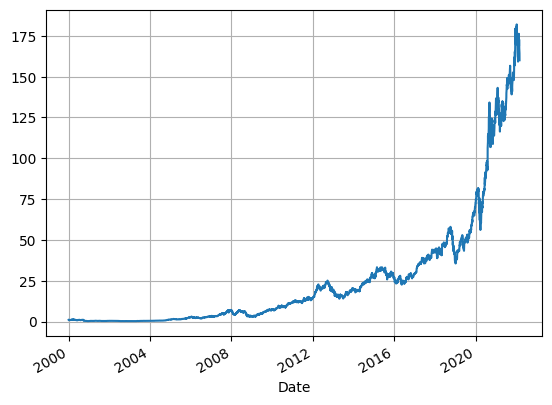

In [ ]:
# 시작일과 종료일 설정
# 우크라이나 러시아 전쟁이 터진 직후의 애플 주식의 저점이였던 날을 end로 잡음
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime(2022, 2, 24)

# yahoo 에서 애플 불러오기 
df = yf.download('AAPL', start=start, end=end)

df.head(5)
df.tail(5)
df.Close.plot(grid=True)

#데이터셋 준비

In [ ]:
"""
open 시가
high 고가
low 저가
close 종가
volume 거래량
Adj Close 주식의 분할, 배당, 배분 등을 고려해 조정한 종가
"""
X = df.drop(columns='Volume')
y = df.iloc[:, 5:6]

print(X)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2000-01-03    0.936384    1.004464    0.907924    0.999442    0.849469
2000-01-04    0.966518    0.987723    0.903460    0.915179    0.777850
2000-01-05    0.926339    0.987165    0.919643    0.928571    0.789232
2000-01-06    0.947545    0.955357    0.848214    0.848214    0.720933
2000-01-07    0.861607    0.901786    0.852679    0.888393    0.755083
...                ...         ...         ...         ...         ...
2022-02-16  171.850006  173.339996  170.050003  172.550003  171.274139
2022-02-17  171.029999  171.910004  168.470001  168.880005  167.631271
2022-02-18  169.820007  170.539993  166.190002  167.300003  166.062943
2022-02-22  164.979996  166.690002  162.149994  164.320007  163.104996
2022-02-23  165.539993  166.149994  159.750000  160.070007  158.886429

[5572 rows x 5 columns]
               Volume
Date                 
2000-01-

#데이터셋 normalization

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 

# Train 데이터
X_train = X_ss[:4500, :]
X_test = X_ss[4500:, :]

# Test 데이터
y_train = y_mm[:4500, :]
y_test = y_mm[4500:, :] 

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (4500, 5) (4500, 1)
Testing Shape (1072, 5) (1072, 1)


#데이터셋을 텐서로 변환

In [ ]:
X_train_tensors = Variable(torch.Tensor(X_train))       # 학습 데이터의 입력 특성을 텐서로 변환
X_test_tensors = Variable(torch.Tensor(X_test))         # 테스트 데이터의 입력 특성을 텐서로 변환

y_train_tensors = Variable(torch.Tensor(y_train))       # 학습 데이터의 출력 레이블을 텐서로 변환
y_test_tensors = Variable(torch.Tensor(y_test))          # 테스트 데이터의 출력 레이블을 텐서로 변환

X_train_tensors_final = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))        # 학습 데이터의 텐서 크기 조정
X_test_tensors_final = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))            # 테스트 데이터의 텐서 크기 조정

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)         # 학습 데이터의 모양 출력
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)             # 테스트 데이터의 모양 출력


Training Shape torch.Size([4500, 1, 5]) torch.Size([4500, 1])
Testing Shape torch.Size([1072, 1, 5]) torch.Size([1072, 1])


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)      # LSTM 레이어 생성
        self.fc = nn.Linear(hidden_size, num_classes)        # 선형 레이어 생성
        self.relu = nn.ReLU()        # ReLU 활성화 함수

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)       # 초기 은닉 상태 생성
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)      # 초기 셀 상태 생성

        out, _ = self.lstm(x, (h_0, c_0))       # LSTM 레이어를 통해 순방향 전파
        out = out[:, -1, :]          # 선택적으로 마지막 시퀀스 출력만 사용할 수 있습니다.
        out = self.relu(out)         # ReLU 적용
        out = self.fc(out)           # 선형 레이어를 통해 출력 계산

        return out


In [ ]:
lstm = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)      # LSTM 모델 인스턴스 생성 및 디바이스에 할당

criterion = nn.MSELoss()      # 평균 제곱 오차(MSE) 손실 함수 정의
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)       # Adam 옵티마이저 생성 및 모델의 파라미터를 등록하여 최적화 수행


In [ ]:
for epoch in range(num_epochs):
    # Forward 패스
    outputs = lstm(X_train_tensors_final.to(device))         # 입력 데이터를 모델에 전달하여 예측값 계산
    loss = criterion(outputs, y_train_tensors.to(device))         # 예측값과 실제 값 사이의 손실 계산

    # Backward 패스 및 최적화
    optimizer.zero_grad()        # 기울기 초기화
    loss.backward()              # backpropagation을 통해 기울기 계산
    optimizer.step()             # 옵티마이저를 사용하여 모델의 파라미터 업데이트

    if (epoch + 1) % 100 == 0:
        print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item()}')        # 일정 간격으로 현재 에포크와 손실 출력


Epoch: 100/30000, Loss: 0.016156906262040138
Epoch: 200/30000, Loss: 0.015763625502586365
Epoch: 300/30000, Loss: 0.015391457825899124
Epoch: 400/30000, Loss: 0.015039408579468727
Epoch: 500/30000, Loss: 0.014706517569720745
Epoch: 600/30000, Loss: 0.01439195778220892
Epoch: 700/30000, Loss: 0.014094934798777103
Epoch: 800/30000, Loss: 0.013814487494528294
Epoch: 900/30000, Loss: 0.013549568131566048
Epoch: 1000/30000, Loss: 0.01329942885786295
Epoch: 1100/30000, Loss: 0.013063114136457443
Epoch: 1200/30000, Loss: 0.012839731760323048
Epoch: 1300/30000, Loss: 0.012628253549337387
Epoch: 1400/30000, Loss: 0.012427661567926407
Epoch: 1500/30000, Loss: 0.0122368847951293
Epoch: 1600/30000, Loss: 0.012054943479597569
Epoch: 1700/30000, Loss: 0.011880794540047646
Epoch: 1800/30000, Loss: 0.011713518761098385
Epoch: 1900/30000, Loss: 0.011552086099982262
Epoch: 2000/30000, Loss: 0.011395570822060108
Epoch: 2100/30000, Loss: 0.011243123561143875
Epoch: 2200/30000, Loss: 0.01109396107494831
Ep

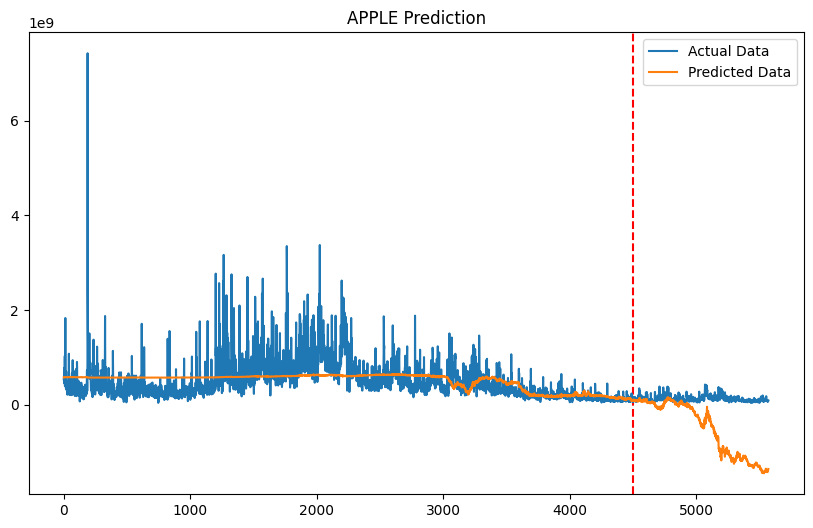

In [ ]:
df_X_ss = ss.transform(df.drop(columns='Volume'))        # 입력 데이터에 대한 스케일링 수행
df_y_mm = mm.transform(df.iloc[:, 5:6])                  # 출력 데이터에 대한 스케일링 수행

df_X_ss = torch.Tensor(df_X_ss).to(device)               # Tensor로 변환 및 장치 설정
df_y_mm = torch.Tensor(df_y_mm).to(device)

df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))         # 입력 데이터의 크기 재조정

lstm.eval()         # 모델을 평가 모드로 설정
with torch.no_grad():
    test_outputs = lstm(df_X_ss.to(device))         # 모델을 사용하여 예측 결과 계산

# 예측 결과와 실제 값 역변환
test_outputs = test_outputs.cpu().numpy()                  # 예측 결과를 넘파이 배열로 변환
test_outputs = mm.inverse_transform(test_outputs)          # 예측 결과에 대한 역변환 수행
df_y = mm.inverse_transform(df_y_mm.data.cpu().numpy())    # 실제 값에 대한 역변환 수행

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.axvline(x=4500, c='r', linestyle='--')                # 테스트 데이터와 학습 데이터의 구분을 나타내는 수직선

plt.plot(df_y, label='Actual Data')                       # 실제 값 그래프 그리기
plt.plot(test_outputs, label='Predicted Data')            # 예측 결과 그래프 그리기
plt.title('APPLE Prediction')
plt.legend()
plt.show()
